TensorFlow Version: 2.19.0
Num GPUs Available: 0

Setting up data generators...
Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 3360 images for training.
Found 840 images for validation.
Classes detected: {'Normal': 0, 'Tuberculosis': 1}

Building the CNN architecture...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,817 (20.61 MB)

 Trainable params: 5,402,369 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)


Configuring callbacks...

Starting model training...
Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8864 - loss: 0.5163
Epoch 1: val_accuracy improved from -inf to 0.17381, saving model to ..\model\tb_cnn_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8868 - loss: 0.5140 - val_accuracy: 0.1738 - val_loss: 1.3617 - learning_rate: 1.0000e-04
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.9490 - loss: 0.1495
Epoch 2: val_accuracy improved from 0.17381 to 0.59643, saving model to ..\model\tb_cnn_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 91s 861ms/step - accuracy: 0.9490 - loss: 0.1494 - val_accuracy: 0.5964 - val_loss: 0.9795 - learning_rate: 1.0000e-04
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9677 - loss: 0.1118
Epoch 3: val_accuracy improved from 0.59643 to 0.89167, saving model to ..\model\tb_cnn_model_best.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 88s 838ms/step - accuracy: 0.9676 - loss: 0.1119 -

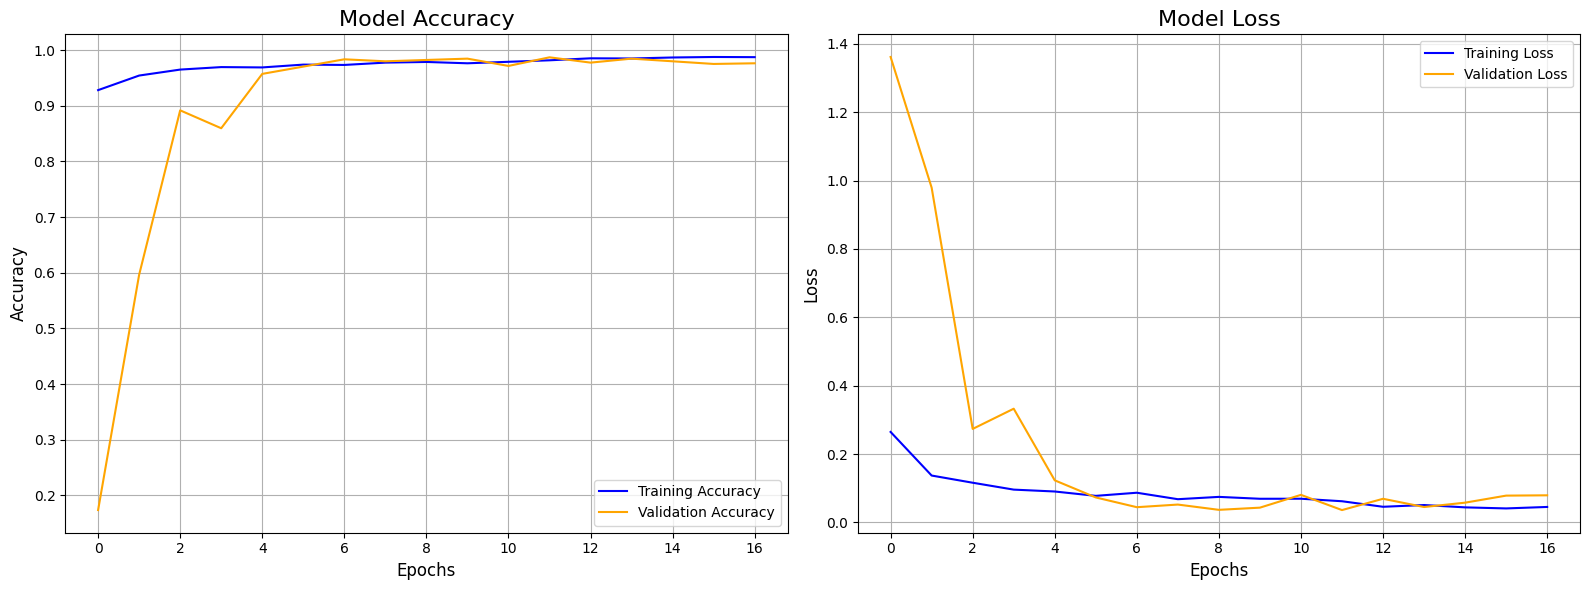


Final evaluation of the best model on the validation set...
  -> Loss    : 0.0360
  -> Accuracy: 98.69%


In [2]:
# ==============================================================================
#                 CNN MODEL TRAINING FOR TUBERCULOSIS DETECTION
# ==============================================================================

# --- 1. Library Imports ---
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Import de l'optimiseur Adam pour réglage
from tensorflow.keras.optimizers import Adam 

print(f"TensorFlow Version: {tf.__version__}")
# Vérification de l'utilisation du GPU
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

# --- 2. Constants and Configuration ---
IMG_SIZE = (150, 150) # CHANGEMENT: Taille réduite pour accélérer
BATCH_SIZE = 32
# Path to the dataset directory. 
DATA_DIR = os.path.join('..', 'data', 'TB_Chest_Radiography_Database')
# Path to save the best trained model. 
MODEL_SAVE_PATH = os.path.join('..', 'model', 'tb_cnn_model_best.keras')

# --- 3. Data Loading and Augmentation ---
print("\nSetting up data generators...")

# Generator for the training set: applies data augmentation to prevent overfitting.
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    validation_split=0.2,    # Reserve 20% of data for validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator for the validation set: 
# only rescales pixels. 
# No augmentation is applied.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data from the directory
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    subset='training',
    target_size=IMG_SIZE, # Utilise la nouvelle taille
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

# Load validation data from the directory
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    subset='validation',
    target_size=IMG_SIZE, # Utilise la nouvelle taille
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"Found {train_generator.samples} images for training.")
print(f"Found {validation_generator.samples} images for validation.")
print(f"Classes detected: {train_generator.class_indices}")

# --- 4. Model Architecture Definition ---
print("\nBuilding the CNN architecture...")

model = Sequential([
    
    Input(shape=(150, 150, 3)), 
    
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Classification Head
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(1, activation='sigmoid') # Sigmoid activation for binary classification
])

# CHANGEMENT: Définir un optimiseur avec un learning rate plus faible
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's architecture summary
model.summary()

# --- 5. Callbacks Configuration ---
print("\nConfiguring callbacks...")

os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# Callback to save only the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback to stop training early if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True,
    verbose=1
)

# Callback to reduce learning rate when performance plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# --- 6. Model Training ---
print("\nStarting model training...")

history = model.fit(
    train_generator,
    epochs=25, # Maximum number of epochs
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\n✅ Training finished!")

# --- 7. Performance Visualization ---
print("\nPlotting training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot training and validation loss values
ax2.plot(history.history['loss'], label='Training Loss', color='blue')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax2.set_title('Model Loss', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- 8. Final Model Evaluation ---
# The `restore_best_weights` callback has already loaded the best model weights.
print("\nFinal evaluation of the best model on the validation set...")
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print(f"  -> Loss    : {loss:.4f}")
print(f"  -> Accuracy: {accuracy:.2%}")